In [2]:
!pip install patchify

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
from patchify import patchify
import os
from PIL import Image
from glob import glob
from tqdm import tqdm



# Dataset Subclass

In [32]:
class change_detection_dataset(Dataset):
    def __init__(self,root_path,patch_size) -> None:
        super().__init__()
        self.patch_size = patch_size
        self.pre_change_path = os.path.join(root_path,"A")
        self.post_change_path = os.path.join(root_path,"B")
        self.change_label_path = os.path.join(root_path,"label")
        self.fname_list=os.listdir(self.pre_change_path)

    def __getitem__(self, index):
        fname = self.fname_list[index]
        pre_img = Image.open(os.path.join(self.pre_change_path,fname)).convert("RGB")
        post_img = Image.open(os.path.join(self.post_change_path,fname)).convert("RGB")
        change_label = Image.open(os.path.join(self.change_label_path,fname)).convert("1")
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
        transform2=transforms.Compose([
            transforms.ToTensor(),
        ])
        pre_tensor = transform(pre_img)
        post_tensor = transform(post_img)
        label_tensor = transform2(change_label)

        pre_tensor_patches = self.create_patches(pre_tensor )    ## we only patch the images , but labels are NOT patched
        post_tensor_patches = self.create_patches( post_tensor)

        # return {'pre':pre_tensor_patches,'post':post_tensor_patches,'label':label_tensor,'fname':fname}
        return pre_tensor_patches, post_tensor_patches, label_tensor, fname

    def create_patches(self, image):
        '''create image patches'''
        image_np = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
        patches = patchify(image_np, (self.patch_size, self.patch_size, image_np.shape[2]), step=self.patch_size)
        patches = patches.reshape(-1, self.patch_size, self.patch_size, image_np.shape[2])  # Flatten patches
        patches = torch.tensor(patches).permute(0, 3, 1, 2)  # Convert to (num_patches, C, patch_size, patch_size)
        patches = patches.reshape(256, 768)

        return patches


    def __len__(self):
        return len(self.fname_list)

# Check the size of dataset output

In [46]:
patch_size = 16
train_path="D://Datasets//Levir_croped_256//LEVIR_CD//train"
dataset = change_detection_dataset(train_path, patch_size )

# # Iterate through the dataset
for x, y, l, n in dataset:
    print(x.shape)  # Each item will be of shape (num_patches, C, patch_size, patch_size)
    print(y.shape)
    print(l.shape)
    print(n)
    print (x.device)
    print (y.device)
    print (x.dtype)
    print (y.dtype)
    print (l.dtype)
    break

torch.Size([256, 768])
torch.Size([256, 768])
torch.Size([1, 256, 256])
train_10_0.png
cpu
cpu
torch.float32
torch.float32
torch.float32


# Dataloader

In [34]:
patch_size = 16
train_path="D://Datasets//Levir_croped_256//LEVIR_CD//train"
test_path="D://Datasets//Levir_croped_256//LEVIR_CD//test"
val_path="D://Datasets//Levir_croped_256//LEVIR_CD//val"


train_loader=DataLoader(change_detection_dataset(root_path=train_path, patch_size=patch_size),batch_size=8,shuffle=True,num_workers=0,pin_memory=False)
test_loader=DataLoader(change_detection_dataset(root_path=test_path, patch_size=patch_size),batch_size=4,shuffle=False,num_workers=0,pin_memory=False)
val_loader=DataLoader(change_detection_dataset(root_path=val_path, patch_size=patch_size),batch_size=8,shuffle=False,num_workers=0,pin_memory=False)

In [36]:
for x, y, l, f in train_loader:
        print (x.shape)     ## 8, 256, 768      --> we already put batch=8
        print (y.shape)     ## 8, 1, 256, 256   --> we already put batch=8
        print (l.shape)     ## 8, 1, 256, 256   --> we already put batch=8
        print (f)
        print (x.device)
        break

torch.Size([8, 256, 768])
torch.Size([8, 256, 768])
torch.Size([8, 1, 256, 256])
('train_15_2.png', 'train_6_3.png', 'train_3_7.png', 'train_7_8.png', 'train_9_2.png', 'train_13_0.png', 'train_14_13.png', 'train_5_13.png')
cpu


# Display a sample from the dataset

In [ ]:
x1 = x[0]
print (x1.shape)
y1 = y[0]
print (y1.shape)
l1 = l[0]
print (l1.shape)

torch.Size([256, 768])
torch.Size([256, 768])
torch.Size([1, 256, 256])


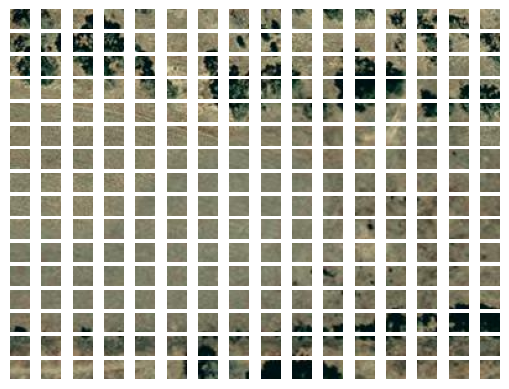

In [ ]:
for i in range(16):
  for j in range(16):
    plt.subplot(16,16,i*16+j+1)
    plt.imshow(x1[i*16+j].reshape(3, 16, 16).permute(1, 2, 0).numpy())
    plt.axis('off')

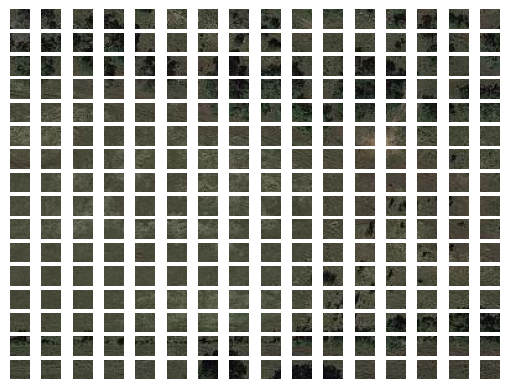

In [ ]:
for i in range(16):
  for j in range(16):
    plt.subplot(16,16,i*16+j+1)
    plt.imshow(y1[i*16+j].reshape(3, 16, 16).permute(1, 2, 0).numpy())
    plt.axis('off')

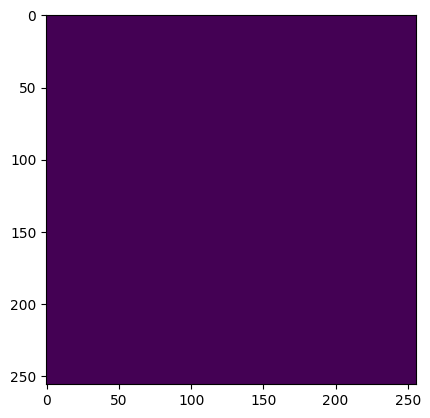

In [ ]:
plt.imshow(l1.permute(1, 2, 0).numpy())

# Building the Model

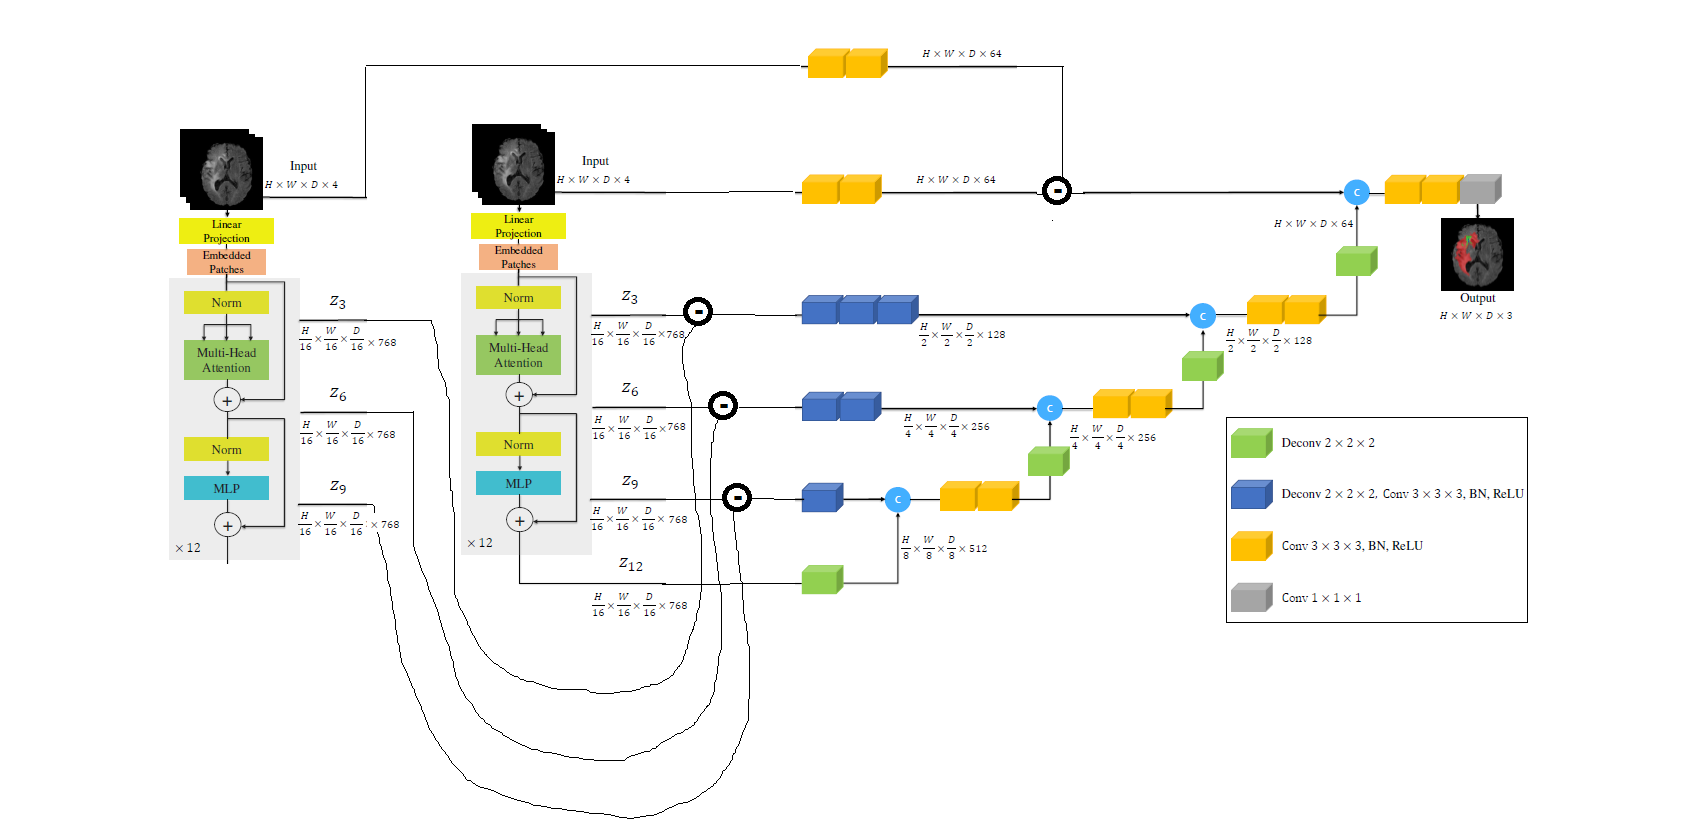# New Section

In [37]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )


    def forward(self, x):
        return self.layers(x)


class DeconvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.deconv = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        return self.deconv(x)


class UNETR_2D_CD(nn.Module):
    def __init__(self, cf, device=None):
        super().__init__()
        self.cf = cf
        self.device = device

        """ Patch + Position Embeddings """
        self.patch_embed = nn.Linear(
            cf["patch_size"]*cf["patch_size"]*cf["num_channels"],
            cf["hidden_dim"],
            device=self.device
        )

        self.positions = torch.arange(start=0, end=cf["num_patches"], step=1, dtype=torch.int32).to(self.device)
        self.pos_embed = nn.Embedding(cf["num_patches"], cf["hidden_dim"]).to(self.device) 
        # self.pos_embed = nn.Parameter(torch.randn(1, cf["num_patches"], cf["hidden_dim"]))

        """ Transformer Encoder """
        self.trans_encoder_layers = []

        for i in range(cf["num_layers"]):
            layer = nn.TransformerEncoderLayer(
                d_model=cf["hidden_dim"],
                nhead=cf["num_heads"],
                dim_feedforward=cf["mlp_dim"],
                dropout=cf["dropout_rate"],
                activation=nn.GELU(),
                batch_first=True,
                device=self.device
            )
            self.trans_encoder_layers.append(layer)


        """ CNN Decoder """
        ## Decoder 1
        self.d1 = DeconvBlock(cf["hidden_dim"], 512)
        self.s1 = nn.Sequential(
            DeconvBlock(cf["hidden_dim"], 512),
            ConvBlock(512, 512)
        )
        self.c1 = nn.Sequential(
            ConvBlock(512+512, 512),
            ConvBlock(512, 512)
        )

        ## Decoder 2
        self.d2 = DeconvBlock(512, 256)
        self.s2 = nn.Sequential(
            DeconvBlock(cf["hidden_dim"], 256),
            ConvBlock(256, 256),
            DeconvBlock(256, 256),
            ConvBlock(256, 256)
        )
        self.c2 = nn.Sequential(
            ConvBlock(256+256, 256),
            ConvBlock(256, 256)
        )

        ## Decoder 3
        self.d3 = DeconvBlock(256, 128)
        self.s3 = nn.Sequential(
            DeconvBlock(cf["hidden_dim"], 128),
            ConvBlock(128, 128),
            DeconvBlock(128, 128),
            ConvBlock(128, 128),
            DeconvBlock(128, 128),
            ConvBlock(128, 128)
        )
        self.c3 = nn.Sequential(
            ConvBlock(128+128, 128),
            ConvBlock(128, 128)
        )

        ## Decoder 4
        self.d4 = DeconvBlock(128, 64)
        self.s4 = nn.Sequential(
            ConvBlock(3, 64),
            ConvBlock(64, 64)
        )
        self.c4 = nn.Sequential(
            ConvBlock(64+64, 64),
            ConvBlock(64, 64)
        )

        """ Output """
        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def to(self, device):
        super().to(device)
        self.device = device  # Store device when moved
        return self

    def forward(self, m, n):
        """ Patch + Position Embeddings """
        print (f'm device is: {m.device}')
        print (f'n device is: {n.device}')
        patch_embed1 = self.patch_embed(m).to(self.device)   ## [8, 256, 768]
        positions = self.positions.to(self.device) 
        pos_embed = self.pos_embed(positions).to(self.device)    ## [256, 768]
        # pos_embed = self.pos_embed
        

        x = patch_embed1 + pos_embed ## [8, 256, 768]
        x = x.to(self.device)

        patch_embed2 = self.patch_embed(n).to(self.device)    ## [8, 256, 768]
        y = patch_embed2 + pos_embed ## [8, 256, 768]
        y = y.to(self.device)

        """ Transformer Encoder """
        skip_connection_index = [3, 6, 9, 12]
        skip_connections1 = []
        skip_connections2 = []

        for i in range(self.cf["num_layers"]):
            layer = self.trans_encoder_layers[i]
            x = layer(x)

            if (i+1) in skip_connection_index:
                skip_connections1.append(x)

        for j in range(self.cf["num_layers"]):
            layer = self.trans_encoder_layers[j]
            y = layer(y)

            if (j+1) in skip_connection_index:
                skip_connections2.append(y)

        """ CNN Decoder """
        x_z3, x_z6, x_z9, x_z12 = skip_connections1
        y_z3, y_z6, y_z9, y_z12 = skip_connections2

        ## Reshaping
        batch = m.shape[0]
        x_z0 = m.view((batch, self.cf["num_channels"], self.cf["image_size"], self.cf["image_size"]))
        y_z0 = n.view((batch, self.cf["num_channels"], self.cf["image_size"], self.cf["image_size"]))

        shape = (batch, self.cf["hidden_dim"], self.cf["patch_size"], self.cf["patch_size"])
        x_z3 = x_z3.view(shape)
        x_z6 = x_z6.view(shape)
        x_z9 = x_z9.view(shape)
        x_z12 = x_z12.view(shape)

        y_z3 = y_z3.view(shape)
        y_z6 = y_z6.view(shape)
        y_z9 = y_z9.view(shape)
        y_z12 = y_z12.view(shape)

        ## Decoder 1
        x = self.d1(x_z12)
        s = self.s1(torch.abs(x_z9-y_z9))
        x = torch.cat([x, s], dim=1)
        x = self.c1(x)

        ## Decoder 2
        x = self.d2(x)
        s = self.s2(torch.abs(x_z6-y_z6))
        x = torch.cat([x, s], dim=1)
        x = self.c2(x)

        ## Decoder 3
        x = self.d3(x)
        s = self.s3(torch.abs(x_z3-y_z3))
        x = torch.cat([x, s], dim=1)
        x = self.c3(x)

        ## Decoder 4
        x = self.d4(x)
        s1 = self.s4(x_z0)
        s2 = self.s4(y_z0)
        s = torch.abs(s1-s2)
        x = torch.cat([x, s], dim=1)
        x = self.c4(x)

        """ Output """
        output = self.output(x)

        return output

In [61]:
config = {}
config["image_size"] = 256
config["num_layers"] = 12
config["hidden_dim"] = 768
config["mlp_dim"] = 3072
config["num_heads"] = 12
config["dropout_rate"] = 0.1
config["num_patches"] = 256
config["patch_size"] = 16
config["num_channels"] = 3

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

# T1= torch.rand(8,3,256,256)
# T2= torch.rand(8,3,256,256)
size=(8, 3,256,256)
T1= torch.rand(size, dtype=torch.float32).to(device)
T2= torch.rand(size, dtype=torch.float32).to(device)

model=UNETR_2D_CD(config, device)
model=model.to(device)

output=model(T1,T2)
print(output.shape)

cpu
m device is: cpu
n device is: cpu


RuntimeError: mat1 and mat2 shapes cannot be multiplied (6144x256 and 768x768)

# Train Function

In [ ]:
# def train(model, train_loader, val_loader, optimizer, loss_function, device, num_epochs, save_path):
#     for epoch in range(num_epochs):
#         loss_list=[]
#         model.train()
#         for _, data in enumerate(train_loader):
#             optimizer.zero_grad()
#             pre_tensor, post_tensor, label_tensor, fname = data
#             pre_tensor = pre_tensor.to(device)
#             post_tensor = post_tensor.to(device)
#             label_tensor = label_tensor.to(device)
#             prediction = model(pre_tensor, post_tensor)
#             total_loss=loss_function(prediction,label_tensor)
#             loss_list.append(total_loss.item()) #only append the loss value and ignore the grad to save memory
#             total_loss.backward()
#             optimizer.step()
#         loss_avg=sum(loss_list)/len(loss_list)
#         print(f'Epoch {epoch} training completed, the average loss is {loss_avg}.')

#         if (epoch+1) % 10==0:
#             model.eval()
#             OA_list=[]
#             for _, data in enumerate(val_loader):
#                 pre_tensor, post_tensor, label_tensor, fname = data
#                 pre_tensor = pre_tensor.to(device)
#                 post_tensor = post_tensor.to(device)
#                 label_tensor = label_tensor.to(device)
#                 probs = model(pre_tensor, post_tensor)
#                 prediction = torch.where(probs>0.5,1,0)
#                 true_count=torch.sum(prediction==label_tensor)
#                 OA=true_count/prediction.numel()
#                 OA_list.append(OA)
#             print("*"*10)
#             print(f'Epoch {epoch} evaluation completed, the average OA is {sum(OA_list)/len(OA_list)}')
#             print("*"*10)
#             torch.save(model.state_dict(),os.path.join(save_path,"UNETR_2D_CD"+str(epoch)+".pth"))

# Training

In [ ]:
# device="cuda" if torch.cuda.is_available() else "cpu"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = torch.device('cpu')  # Change to CPU
model = UNETR_2D_CD(config, device)
print(device)

# model = UNETR_2D_CD(config, device)
# model = model.to(device)

# if model.parameters():
#   for param in model.parameters():
#     print(param.device)  # Print the device of the first parameter
#     # break  # Exit the loop after printing one device
# else:
#   print("Model has no parameters.")

# print(model.device)  # This will print the device of the model
# print(model.trans_encoder_layers[0].self_attn.in_proj_weight.device)


optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
loss_function = torch.nn.BCELoss().to(device)
num_epochs = 30
save_path ="./checkpoint/"
os.makedirs(save_path, exist_ok=True)
# train(model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, loss_function=loss_function, device=device, num_epochs=num_epochs, save_path=save_path)



for epoch in range(num_epochs):
        loss_list=[]
        model.train()
        for _, data in enumerate(train_loader):
            optimizer.zero_grad()
            pre_tensor, post_tensor, label_tensor, fname = data
            pre_tensor = pre_tensor.to(device)
            post_tensor = post_tensor.to(device)
            label_tensor = label_tensor.to(device)

            prediction = model(pre_tensor, post_tensor)
            print (prediction.shape)

            # Get the minimum value in the tensor
            min_value = torch.min(prediction)
            print(f"Minimum value: {min_value}")
            # Get the maximum value in the tensor
            max_value = torch.max(prediction)
            print(f"Maximum value: {max_value}")





            prediction = torch.sigmoid(prediction)
            total_loss=loss_function(prediction,label_tensor)
            loss_list.append(total_loss.item())                 #only append the loss value and ignore the grad to save memory
            total_loss.backward()
            optimizer.step()
        loss_avg=sum(loss_list)/len(loss_list)
        print(f'Epoch {epoch} training completed, the average loss is {loss_avg}.')

        if (epoch+1) % 10==0:
            model.eval()
            OA_list=[]
            for _, data in enumerate(val_loader):
                pre_tensor, post_tensor, label_tensor, fname = data
                pre_tensor = pre_tensor.to(device)
                post_tensor = post_tensor.to(device)
                label_tensor = label_tensor.to(device)

                probs = model(pre_tensor, post_tensor)
                prediction = torch.where(probs>0.5,1,0)
                true_count=torch.sum(prediction==label_tensor)
                OA=true_count/prediction.numel()
                OA_list.append(OA)
            print("*"*10)
            print(f'Epoch {epoch} evaluation completed, the average OA is {sum(OA_list)/len(OA_list)}')
            print("*"*10)
            torch.save(model.state_dict(),os.path.join(save_path,"UNETR_2D_CD"+str(epoch)+".pth"))

cpu
m device is: cpu
n device is: cpu
torch.Size([8, 1, 256, 256])
Minimum value: -2.1423022747039795
Maximum value: 2.3302559852600098
Range of values: 4.47255802154541


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Confusion Matrix Function

In [ ]:
def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

# Testing

In [ ]:
model = UNETR_2D_CD()
model=model.to(device)
model.load_state_dict(torch.load("./checkpoint/ResUnet19.pth"))

test_results_path="./test_results/"
os.makedirs(test_results_path,exist_ok=True)
TP=0
TN=0
FP=0
FN=0
for _, data in enumerate(test_loader):
    pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
    pre_tensor = pre_tensor.to(device)
    post_tensor = post_tensor.to(device)
    label_tensor = label_tensor.to(device)
    probs = model(pre_tensor, post_tensor)
    prediction = torch.where(probs>0.5,1.0,0.0)
    true_positives, false_positives, true_negatives, false_negatives = confusion(prediction,label_tensor)
    TP+=true_positives
    TN+=true_negatives
    FP+=false_positives
    FN+=false_negatives
    for i in range(prediction.shape[0]):
        save_image(prediction[i,:,:,:].cpu(), os.path.join(test_results_path, fname[i]))


# View Results

In [ ]:
pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
fig=plt.figure()

preplot=fig.add_subplot(131)
preplot.imshow(pre_tensor[1,:,:,:].permute(1,2,0).numpy())
preplot.set_title("pre-change")

postplot=fig.add_subplot(132)
postplot.set_title("post-change")
postplot.imshow(post_tensor[1,:,:,:].permute(1,2,0).numpy())

labelplot=fig.add_subplot(133)
labelplot.set_title("prediction")
labelplot.imshow(prediction[1,:,:,:].permute(1,2,0).cpu().numpy())
# transforms.ToPILImage()(pre_tensor[0,:,:,:])
# transforms.ToPILImage()(post_tensor[0,:,:,:])
# transforms.ToPILImage()(label_tensor[0,:,:,:])
print(f'fname={fname[0]}')

# Calculate OA, Precision, Recall, F1-score

In [ ]:
OA=(TP+TN)/(TP+TN+FP+FN)
Precision=TP/(TP+FP)
Recall=TP/(TP+FN)
F1_score=2*Precision*Recall/(Precision+Recall)

print(f'OA={OA:.3f}, Precision={Precision:.3f}, Recall={Recall:.3f}, F1-score={F1_score:.3f}')